In [33]:
import os, time, datetime
import numpy as np
import cv2
import torch

In [34]:
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [35]:
set_names_list = ['iso1600', 'iso3200']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=3, out_channels=3, init_features=32)

args = {'model_dir': 'dng', 'model_name': 'best_model.pth'}
model.load_state_dict(torch.load(r'/home/sj/autoencoder/best_model.pth', map_location=torch.device('cpu')))
model = model.to(device)
# model.eval()  # Set model to evaluate mode
print('model loaded')

model loaded


In [49]:
from torchvision import transforms
import rawpy
from PIL import Image

set_dir = 'dataset/night_real'

transform = transforms.Compose([
    # transforms.Resize((36, 36)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

path = r'/home/sj/autoencoder/dataset/night_real/dng/iso_3200/038.dng'

with rawpy.imread(path) as raw:
    img = raw.postprocess()

tensor_img = Image.fromarray(img)
if transform:
    tensor_img = transform(tensor_img)

tensor_img = tensor_img.unsqueeze(0).to(device)

print(tensor_img.shape)
with torch.no_grad():
    y_ = model(tensor_img) 

    import matplotlib.pyplot as plt

    # Assuming `y_` is the output of the model
    output = y_.detach().cpu().numpy()


torch.Size([1, 3, 3024, 4032])


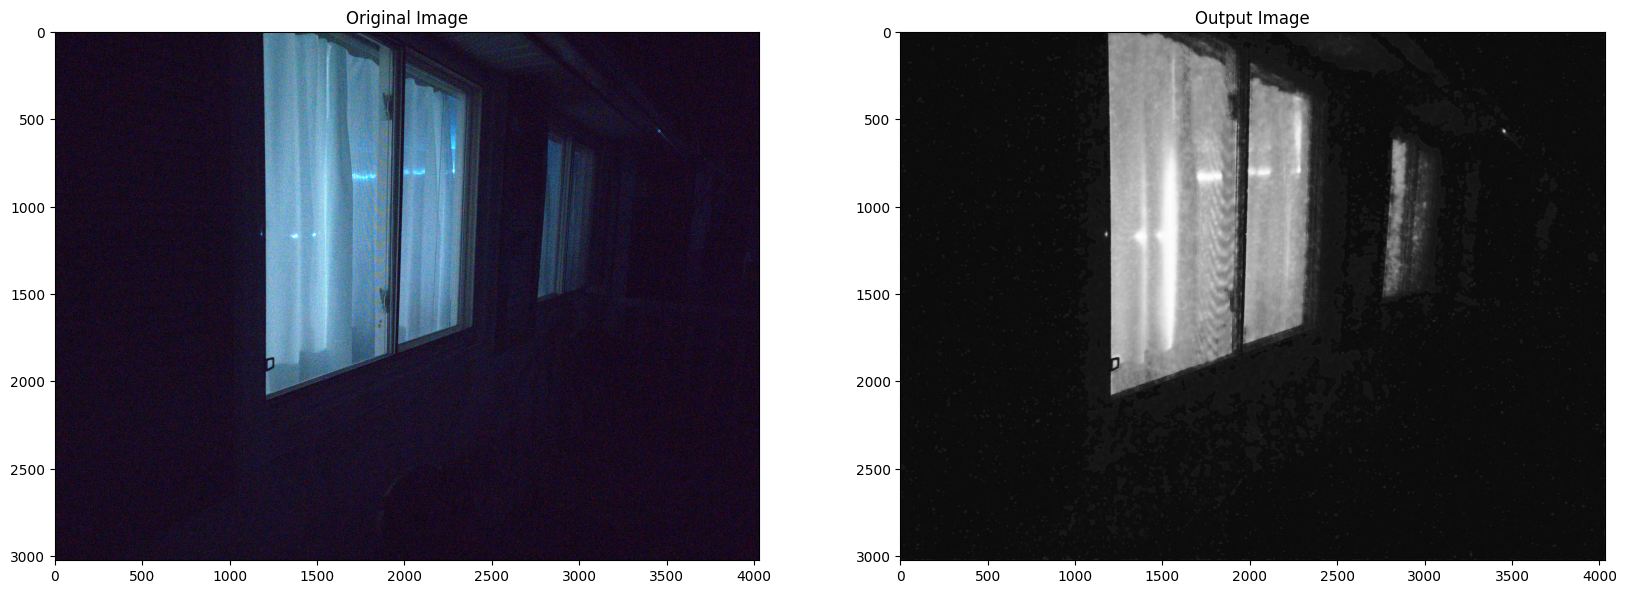

In [39]:
# Visualize the output
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(20, 10))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.axis('on')
plt.title('Original Image')

# Display the output image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output[0, 0, :, :], cv2.COLOR_RGB2BGR))
plt.axis('on')
plt.title('Output Image')

plt.show()


(1, 3, 3024, 4032)


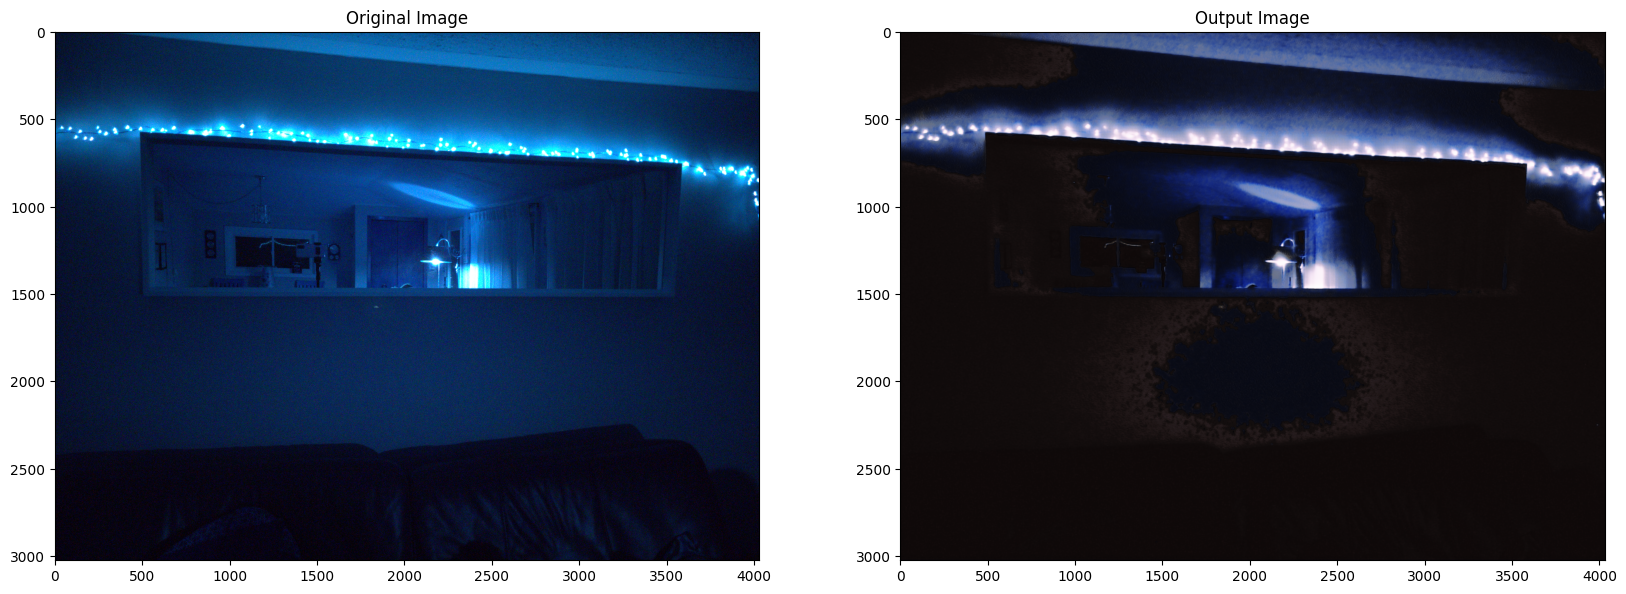

In [50]:
# Visualize the output
import matplotlib.pyplot as plt
import cv2
import numpy as np

print(output.shape)
# Convert the tensor back to a numpy array
# img_np = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # (H, W, C)
output_tensor = torch.tensor(output)
output_np = output_tensor.squeeze(0).permute(1, 2, 0)  # (H, W, C)

# Rescale the values to [0, 255] and convert to uint8
# img_np = (img_np * 255).astype(np.uint8)
output_np = (output_np * 255).numpy().astype(np.uint8)

plt.figure(figsize=(20, 10))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.axis('on')
plt.title('Original Image')

# Display the output image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output_np, cv2.COLOR_RGB2BGR))
plt.axis('on')
plt.title('Output Image')

plt.show()
